## Example ODE with custom library

In this notebook we provide a simple example of the DeepMoD algorithm by applying it on the a non-linear ODE

We start by importing the required DeepMoD functions:

In [1]:
# General imports
import numpy as np
import torch
import matplotlib.pylab as plt

# DeepMoD functions


from deepymod import DeepMoD
from deepymod.data import Dataset, get_train_test_loader
from deepymod.data.samples import Subsample_random
from deepymod.model.func_approx import NN
from deepymod.model.constraint import LeastSquares
from deepymod.model.sparse_estimators import Threshold, PDEFIND
from deepymod.training import train
from deepymod.training.sparsity_scheduler import TrainTestPeriodic
from scipy.io import loadmat


import torch
from torch.autograd import grad
from itertools import combinations
from functools import reduce
from typing import Tuple
from deepymod.utils.types import TensorList
from deepymod import Library

from scipy.integrate import odeint

# Settings for reproducibility
np.random.seed(40)
torch.manual_seed(0)

# Configuring GPU or CPU
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)

cuda


Next, we prepare the dataset. The set of ODEs we consider here are
$d[y, z]/dt = [z, -z+ 5 \sin y]$

In [2]:
def dU_dt_sin(U, t):
    return [U[1], -1 * U[1] - 5 * np.sin(U[0])]


def create_data(U0=np.array([2.5, 0.4]), ts=np.linspace(0, 5, 1000)):
    Y = torch.from_numpy(odeint(dU_dt_sin, U0, ts)).float()
    T = torch.from_numpy(ts.reshape(-1, 1)).float()
    return T, Y

In [3]:
dataset = Dataset(
    create_data,
    preprocess_kwargs={"noise_level": 0.1},
    device=device,
)

Dataset is using device:  cuda


Here we can potentially rescale the Y and T axis and we plot the results

Let's plot it to get an idea of the data:

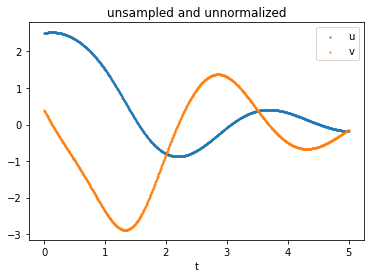

In [4]:
fig, ax = plt.subplots()
ax.scatter(dataset.coords.cpu(), dataset.data[:, 0].cpu(), label="u", s=1)
ax.scatter(dataset.coords.cpu(), dataset.data[:, 1].cpu(), label="v", s=1)
ax.set_xlabel("t")
ax.legend()
ax.set_title("unsampled and unnormalized")
plt.show()

We can add minmax normalization to the coordinates and data by providing this to the preprocess function:

In [5]:
dataset = Dataset(
    create_data,
    preprocess_kwargs={"noise_level": 0.1,  
        "normalize_coords": True,
        "normalize_data": True,},
    device=device
)

Dataset is using device:  cuda


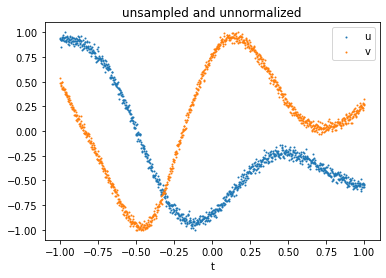

In [6]:
fig, ax = plt.subplots()
ax.scatter(dataset.coords.cpu(), dataset.data[:, 0].cpu(), label="u", s=1)
ax.scatter(dataset.coords.cpu(), dataset.data[:, 1].cpu(), label="v", s=1)
ax.set_xlabel("t")
ax.legend()
ax.set_title("unsampled and unnormalized")
plt.show()

We can now do the same, but also randomly subsample the data:

In [19]:
dataset = Dataset(
    create_data,
    subsampler=Subsample_random,
    subsampler_kwargs={"number_of_samples": 200},
    preprocess_kwargs={
        "noise_level": 0.1,
        "normalize_coords": True,
        "normalize_data": True,
    },
    device=device
)

Dataset is using device:  cuda


Now we need to split our data into a train and test dataloaders for PyTorch

In [20]:
train_dataloader, test_dataloader = get_train_test_loader(dataset, train_test_split=0.5)

# Setup a custom library

In this notebook we show how the user can create a custom build library.The library function, $\theta$, in this case contains $[1,u,v, sin(u)]$ to showcase that non-linear terms can easily be added to the library

In [21]:
from torch.autograd import grad
from itertools import combinations, product
from functools import reduce

In [22]:
class Library_nonlinear(Library):
    """[summary]

    Args:
        Library ([type]): [description]
    """

    def __init__(self) -> None:
        super().__init__()

    def library(
        self, input: Tuple[torch.Tensor, torch.Tensor]
    ) -> Tuple[TensorList, TensorList]:

        prediction, data = input
        samples = prediction.shape[0]
        poly_list = []
        deriv_list = []
        time_deriv_list = []

        # Construct the theta matrix
        C = torch.ones_like(prediction[:, 0]).view(samples, -1)
        u = prediction[:, 0].view(samples, -1)
        v = prediction[:, 1].view(samples, -1)
        theta = torch.cat((C, u, v, torch.sin(u)), dim=1)

        # Construct a list of time_derivatives
        time_deriv_list = []
        for output in torch.arange(prediction.shape[1]):
            dy = grad(
                prediction[:, output],
                data,
                grad_outputs=torch.ones_like(prediction[:, output]),
                create_graph=True,
            )[0]
            time_deriv = dy[:, 0:1]
            time_deriv_list.append(time_deriv)

        return time_deriv_list, [theta, theta]

## Configuring DeepMoD

Configuration of the function approximator: Here the first argument is the number of input and the last argument the number of output layers.

In [23]:
network = NN(1, [30, 30, 30, 30], 2)

Configuration of the library function: We select the custom build library we created earlier

In [24]:
library = Library_nonlinear()

Configuration of the sparsity estimator and sparsity scheduler used. In this case we use the most basic threshold-based Lasso estimator and a scheduler that asseses the validation loss after a given patience. If that value is smaller than 1e-5, the algorithm is converged.

In [25]:
estimator = Threshold(0.5)
sparsity_scheduler = TrainTestPeriodic(periodicity=50, patience=200, delta=1e-5)

Configuration of the sparsity estimator

In [26]:
constraint = LeastSquares()

Now we instantiate the model and select the optimizer

In [27]:
model = DeepMoD(network, library, estimator, constraint).to(device)

Defining optimizer

In [28]:
optimizer = torch.optim.Adam(
    model.parameters(), betas=(0.99, 0.99), amsgrad=True, lr=1e-3
)

## Run DeepMoD

We can now run DeepMoD using all the options we have set and the training data. We need to slightly preprocess the input data for the derivatives:

In [30]:
train(
    model,
    train_dataloader,
    test_dataloader,
    optimizer,
    sparsity_scheduler,
    log_dir="runs/coupled2/",
    max_iterations=5000,
    delta=1e-3,
    patience=100,
)

  4975  MSE: 2.17e-01  Reg: 1.04e-01  L1: 1.12e+01 Algorithm converged. Writing model to disk.


Now that DeepMoD has converged, it has found the following coefficients to not be zero: 

In [32]:
model.sparsity_masks

[tensor([False,  True,  True,  True], device='cuda:0'),
 tensor([False,  True,  True, False], device='cuda:0')]

And it found the following coefficients.

In [31]:
model.estimator_coeffs()

[array([[ 0.       ],
        [ 2.207536 ],
        [-1.4659148],
        [-3.3248534]], dtype=float32),
 array([[0.       ],
        [1.0465378],
        [0.5286931],
        [0.       ]], dtype=float32)]